In [24]:
import torch
import torchvision

In [25]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from Script import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/Gauravsingh564/Food_Vision_App
    !mv  Food_Vision_App/Script .
    !rm -rf Food_Vision_App
    from Script import data_setup, engine

In [26]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Get Data

In [27]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [28]:
# setup the training and testing path
train_dir=image_path/"train"
test_dir=image_path/"test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

###2.1 Creating a transform for `torchvision.models` (manual creation)

In [29]:
from torchvision import transforms
normalize=transforms.Normalize(mean=[0.485,0.456,0.406],
                               std=[0.229,0.224,0.225])

manual_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [30]:
from Script import data_setup
train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)

In [31]:
train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d5c31ed9650>,
 ['pizza', 'steak', 'sushi'])

###2.2 Creating a transform for `torchvision.models` (auto creation)

In [32]:
# Get a set of pretrained model weights
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [33]:
#Get the transform used to create our pretrained weights

auto_transform=weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [34]:
# Create DataLoder with automatic transform

train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transform,
    batch_size=32
)

In [35]:
train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d5c90436b50>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained Model

###3.1 Setting up a pretrained model

In [36]:
model=torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 3.2 Getting a summary of our model

In [37]:
summary(model,
        (1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

###3.3 Freezing the base model and changing the output layer to suit our need

In [38]:
# Freeze all of the base layers in EffNetB0

for param in model.features.parameters():
  param.requires_grad=False

In [39]:
# Update the classifier head of the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.classifier=nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              bias=True)
).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [40]:
summary(model,
        (1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

##4. Train Model

In [41]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [42]:
from Script import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from timeit import default_timer as timer
start_time=timer()
results=engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=5,
             device=device)
end_time=timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:1 | Train_loss:1.0924 | Train_acc:0.3984 | Test_loss:0.9133 | Test_acc:0.5398
Epoch:2 | Train_loss:0.8717 | Train_acc:0.7773 | Test_loss:0.7912 | Test_acc:0.8153
Epoch:3 | Train_loss:0.7648 | Train_acc:0.7930 | Test_loss:0.7463 | Test_acc:0.8561
Epoch:4 | Train_loss:0.7109 | Train_acc:0.7539 | Test_loss:0.6373 | Test_acc:0.8655
Epoch:5 | Train_loss:0.6255 | Train_acc:0.7852 | Test_loss:0.6261 | Test_acc:0.8561
[INFO] Total training time: 11.867 seconds


In [43]:
results

{'train_loss': [1.0924270078539848,
  0.8716965168714523,
  0.7647949680685997,
  0.7108824849128723,
  0.6254763938486576],
 'train_acc': [0.3984375, 0.77734375, 0.79296875, 0.75390625, 0.78515625],
 'test_loss': [0.9132681290308634,
  0.7911976178487142,
  0.7463406324386597,
  0.6373109618822733,
  0.6261006395022074],
 'test_acc': [0.5397727272727273,
  0.8153409090909092,
  0.8560606060606061,
  0.8655303030303031,
  0.8560606060606061]}

##5. Evaluate model by plotting loss curves

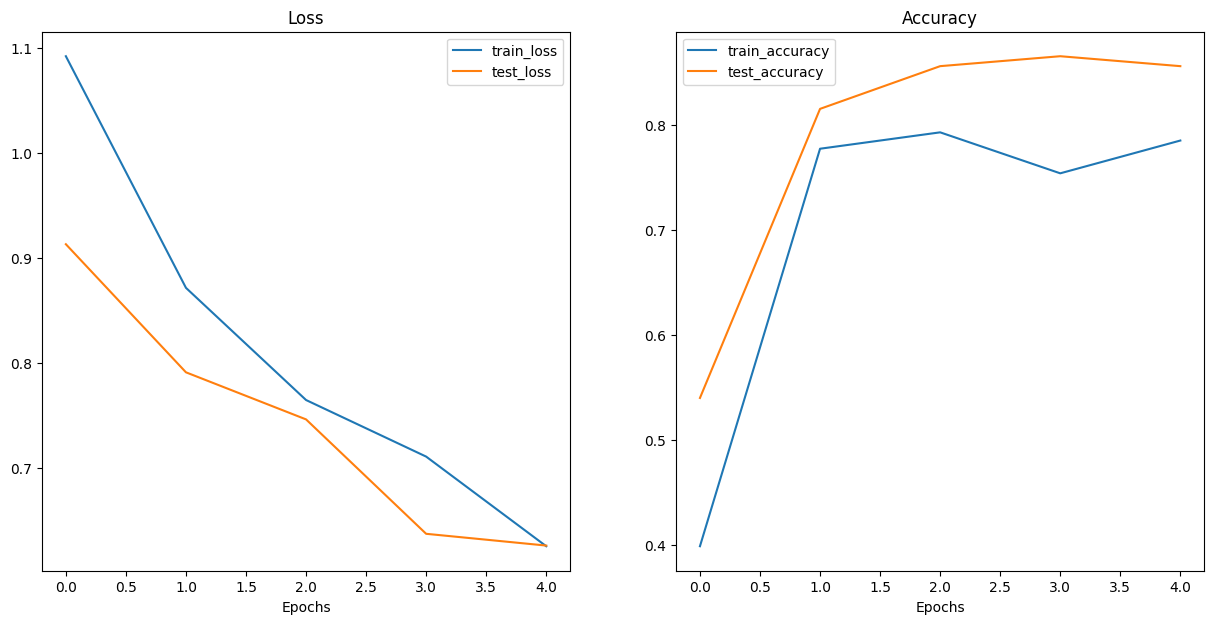

In [44]:
try:
  from helper_functions import plot_loss_curves
except:
  with open("helper_functions.py","wb") as f:
    import requests
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

plot_loss_curves(results)


##6. Make prediction on images from the test set

In [46]:
from typing import List, Tuple
from pathlib import Path
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        class_names: List[str],
                        image_path: str,
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms=None,
                        device: torch.device=device):
  img=Image.open(image_path)

  if transform is not None:
    img_transform=transform
  else:
    img_transform=transforms.Compose([
                                       transforms.Resize(image_size),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485,0.456,0.406],
                                                            std=[0.229,0.224,0.225])
    ])

    model.to(device)

    model.eval()
    with torch.inference_mode():
      img_tensor=img_transform(img).unsqueeze(dim=0)
      img_pred=model(img_tensor.to(device))
      pred_probs=torch.softmax(img_pred,dim=1)
      pred_label=torch.argmax(pred_probs,dim=1)
      plt.figure()
      plt.imshow(img)
      plt.title(f"Pred: {class_names[pred_label]} | Prob: {pred_probs[0][pred_label]}")
      plt.axis(False)




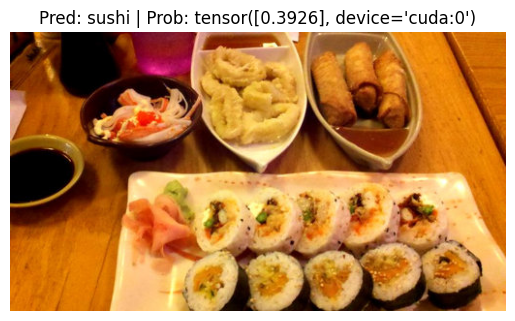

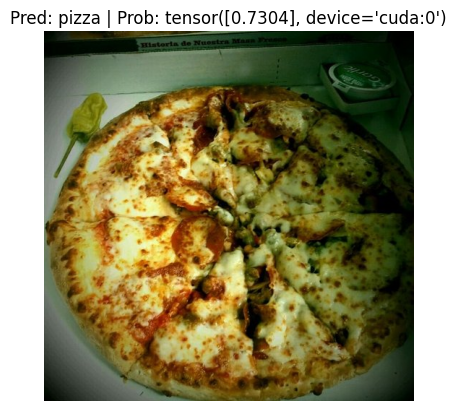

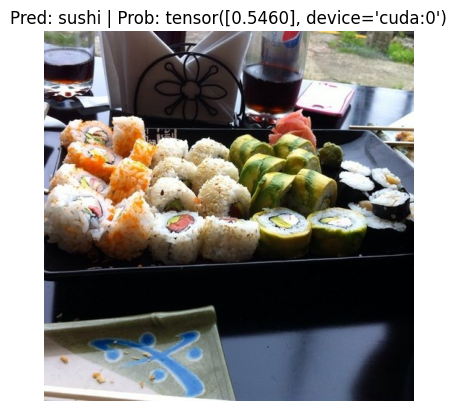

In [55]:
import random

num_images_to_plot=3
test_image_path_list=list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample=random.sample(test_image_path_list,k=num_images_to_plot)

for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      class_names=class_names,
                      image_path=image_path,
                      image_size=(224,224),
                      )

###6.1 Making Prediction on custom Image

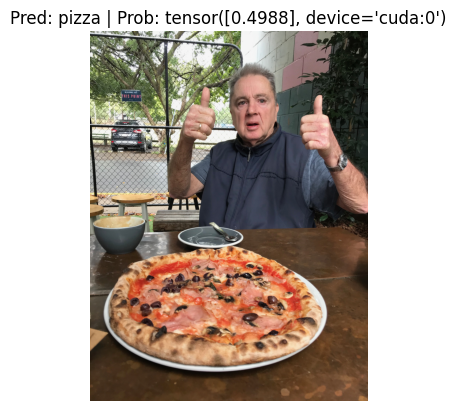

In [61]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)